# Week 4 — Logistic Regression & Feature Scaling

This notebook creates a **binary CKD label from GFR** and compares **Logistic Regression** with and without **feature scaling**.

- Build a binary target: **CKD_flag = 1 if GFR < 60, else 0**
- Compare pipelines (no scaling vs. StandardScaler)
- Tune regularization via **LogisticRegressionCV**
- Evaluate with **Accuracy, Precision, Recall, F1, ROC-AUC**
- Plot ROC curves and show a confusion matrix
- Inspect top positive/negative coefficients (log-odds)

**Dataset:** `Chronic_Kidney_Dsease_data.csv`  
**Original target:** `GFR`  → **Derived label:** `CKD_flag`

In [2]:
# 0) Configuration
DATA_PATH = "Chronic_Kidney_Dsease_data.csv"   
GFR_COL = "GFR"
CKD_THRESHOLD = 60.0  # GFR < 60 → CKD present
TEST_SIZE = 0.2
CV_FOLDS = 5
RANDOM_STATE = 42

# If class imbalance is strong, using class_weight='balanced' can help recall at some cost to precision
USE_CLASS_WEIGHT = True  # set False if you don't want automatic balancing

# Results folder
OUT_DIR = "week4_outputs_ckd"

## 1) Imports

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)

pd.set_option("display.max_columns", 200)
Path(OUT_DIR).mkdir(exist_ok=True)

## 2) Load data & create binary label (CKD_flag)

In [4]:
df = pd.read_csv(DATA_PATH)
assert GFR_COL in df.columns, f"Column '{GFR_COL}' not found. Available: {df.columns.tolist()[:25]}…"

# Create binary label: 1 = CKD present (GFR < 60), 0 = no CKD
df["CKD_flag"] = (df[GFR_COL].astype(float) < CKD_THRESHOLD).astype(int)

print("Loaded:", df.shape)
display(df.head(3))
print("\nClass balance (CKD_flag):\n", df["CKD_flag"].value_counts(normalize=True).rename(lambda x: f"class_{x}"))

# Define X, y
y = df["CKD_flag"]
X = df.drop(columns=["CKD_flag"])  # keep original GFR and other cols as features for now

# Identify types
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Numerical: {len(num_cols)} | Categorical: {len(cat_cols)}")

Loaded: (1659, 55)


,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryKidneyDisease,FamilyHistoryHypertension,FamilyHistoryDiabetes,PreviousAcuteKidneyInjury,UrinaryTractInfections,SystolicBP,DiastolicBP,FastingBloodSugar,HbA1c,SerumCreatinine,BUNLevels,GFR,ProteinInUrine,ACR,SerumElectrolytesSodium,SerumElectrolytesPotassium,SerumElectrolytesCalcium,SerumElectrolytesPhosphorus,HemoglobinLevels,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,ACEInhibitors,Diuretics,NSAIDsUse,Statins,AntidiabeticMedications,Edema,FatigueLevels,NauseaVomiting,MuscleCramps,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge,CKD_flag
0,1,71,0,0,0,2,31.069414,1,5.128112,1.676220,0.240386,4.076434,0,0,0,0,0,113,83,72.510788,9.212397,4.962531,25.605949,45.703204,0.744980,123.849426,137.652501,3.626058,10.314420,3.152648,16.114679,207.728670,85.863656,21.967957,212.095215,0,0,4.563139,1,0,0,3.563894,6.992244,4.518513,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1,Confidential,1
1,2,34,0,0,1,3,29.692119,1,18.609552,8.377574,6.503233,7.652813,1,1,0,0,0,120,67,100.848875,4.604989,3.156799,31.338166,55.784504,3.052317,88.539095,138.141335,5.332871,9.604196,2.855443,15.349205,189.450727,86.378670,87.569756,255.451314,0,0,9.097002,0,0,0,5.327336,0.356290,2.202222,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1,Confidential,1
2,3,80,1,1,0,1,37.394822,1,11.882429,9.607401,2.104828,4.392786,0,0,0,0,0,147,106,160.989441,5.432599,3.698236,39.738169,67.559032,1.157839,21.170892,142.970116,4.330891,9.885786,4.353513,13.018834,284.137622,132.269872,20.049798,251.902583,0,1,3.851249,1,0,0,4.855420,4.674069,5.967271,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1,Confidential,0



Class balance (CKD_flag):
 CKD_flag
class_0    0.56299
class_1    0.43701
Name: proportion, dtype: float64
Numerical: 53 | Categorical: 1


## 3) Train / Test split (stratified)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Train class balance:", y_train.mean().round(3), "(1=CKD)")

Train: (1327, 54) | Test: (332, 54)
Train class balance: 0.437 (1=CKD)


## 4) Preprocessing pipelines (with and without scaling)

In [6]:
# Shared imputers/encoders
num_impute = SimpleImputer(strategy="median")
cat_impute = SimpleImputer(strategy="most_frequent")
onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# A) No-scaling pipeline
pre_no_scale = ColumnTransformer([
    ("num", Pipeline([("imputer", num_impute)]), num_cols),
    ("cat", Pipeline([("imputer", cat_impute), ("onehot", onehot)]), cat_cols)
])

# B) With StandardScaler for numeric
pre_scaled = ColumnTransformer([
    ("num", Pipeline([("imputer", num_impute), ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imputer", cat_impute), ("onehot", onehot)]), cat_cols)
])

class_weight = "balanced" if USE_CLASS_WEIGHT else None

# CV-based logistic regression (strongly recommended over fixed C)
def make_logregcv_pipeline(preprocessor):
    # liblinear handles l1/l2 on smaller data; saga good for large/sparse; we'll use liblinear for robustness
    return Pipeline([
        ("preprocess", preprocessor),
        ("model", LogisticRegressionCV(
            Cs=np.logspace(-3, 3, 10),
            cv=CV_FOLDS,
            penalty="l2",
            solver="liblinear",
            class_weight=class_weight,
            scoring="roc_auc",
            max_iter=1000,
            n_jobs=None
        ))
    ])

pipe_no_scale = make_logregcv_pipeline(pre_no_scale)
pipe_scaled   = make_logregcv_pipeline(pre_scaled)

## 5) Fit models & evaluate (Accuracy, Precision, Recall, F1, ROC-AUC)

In [7]:
def evaluate_classifier(name, pipe, X_tr, X_te, y_tr, y_te):
    pipe.fit(X_tr, y_tr)
    # Predictions
    yhat_tr = pipe.predict(X_tr)
    yhat_te = pipe.predict(X_te)
    # Probabilities for ROC-AUC
    proba_tr = pipe.predict_proba(X_tr)[:, 1]
    proba_te = pipe.predict_proba(X_te)[:, 1]

    def metrics(y_true, y_pred, proba):
        return dict(
            Accuracy=accuracy_score(y_true, y_pred),
            Precision=precision_score(y_true, y_pred, zero_division=0),
            Recall=recall_score(y_true, y_pred, zero_division=0),
            F1=f1_score(y_true, y_pred, zero_division=0),
            ROC_AUC=roc_auc_score(y_true, proba)
        )

    tr = metrics(y_tr, yhat_tr, proba_tr)
    te = metrics(y_te, yhat_te, proba_te)

    row = {
        "Model": name,
        **{f"train_{k}": v for k, v in tr.items()},
        **{f"test_{k}": v for k, v in te.items()}
    }
    return row, pipe

rows = []
row_ns, fitted_ns = evaluate_classifier("LogRegCV — No Scaling", pipe_no_scale, X_train, X_test, y_train, y_test)
rows.append(row_ns)

row_sc, fitted_sc = evaluate_classifier("LogRegCV — Scaled", pipe_scaled, X_train, X_test, y_train, y_test)
rows.append(row_sc)

results = pd.DataFrame(rows)
display(results)

# Save
results.to_csv(Path(OUT_DIR) / "week4_classification_results.csv", index=False)
print("Saved:", (Path(OUT_DIR) / "week4_classification_results.csv").resolve())

,Model,train_Accuracy,train_Precision,train_Recall,train_F1,train_ROC_AUC,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC_AUC
0,LogRegCV — No Scaling,0.998493,0.996564,1.0,0.998279,1.0,0.975904,0.972414,0.972414,0.972414,0.998746
1,LogRegCV — Scaled,1.000000,1.000000,1.0,1.000000,1.0,0.978916,0.992857,0.958621,0.975439,0.998304


Saved: /workspaces/OMDS-ModC-Week4-Uwineza-Annick/week4_outputs_ckd/week4_classification_results.csv


## 6) Classification report & confusion matrix (best model on test set)

Best model: LogRegCV — No Scaling

Classification Report (Test):

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       187
           1       0.97      0.97      0.97       145

    accuracy                           0.98       332
   macro avg       0.98      0.98      0.98       332
weighted avg       0.98      0.98      0.98       332

Confusion Matrix (Test):
 [[183   4]
 [  4 141]]


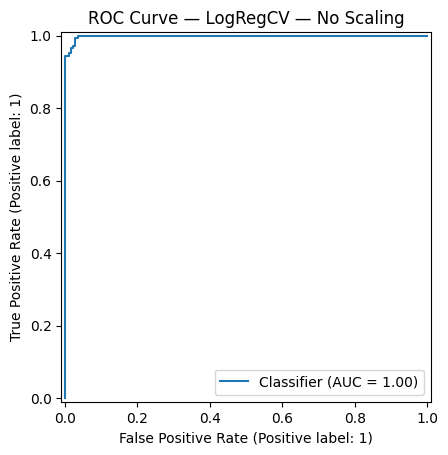

In [8]:
# Pick best by test ROC-AUC; tie-breaker test F1
best_idx = results[["test_ROC_AUC", "test_F1"]].values.argmax(axis=0)[0]
best_row = results.iloc[results["test_ROC_AUC"].idxmax()]
best_name = best_row["Model"]
best_pipe = fitted_sc if "Scaled" in best_name else fitted_ns

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

print(f"Best model: {best_name}\n")
print("Classification Report (Test):\n")
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Test):\n", cm)

# Simple ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC Curve — {best_name}")
plt.show()

## 7) Coefficient inspection (log-odds, top positive/negative)

,feature,coef,abs_coef
23,GFR,-1.120634,1.120634
26,SerumElectrolytesSodium,0.425581,0.425581
10,DietQuality,0.171140,0.171140
42,NauseaVomiting,0.152963,0.152963
4,SocioeconomicStatus,0.150864,0.150864
9,PhysicalActivity,0.133569,0.133569
20,HbA1c,0.084546,0.084546
41,FatigueLevels,-0.079223,0.079223
50,MedicationAdherence,0.077757,0.077757
35,ACEInhibitors,-0.074352,0.074352


Saved: /workspaces/OMDS-ModC-Week4-Uwineza-Annick/week4_outputs_ckd/week4_best_model_coefficients.csv


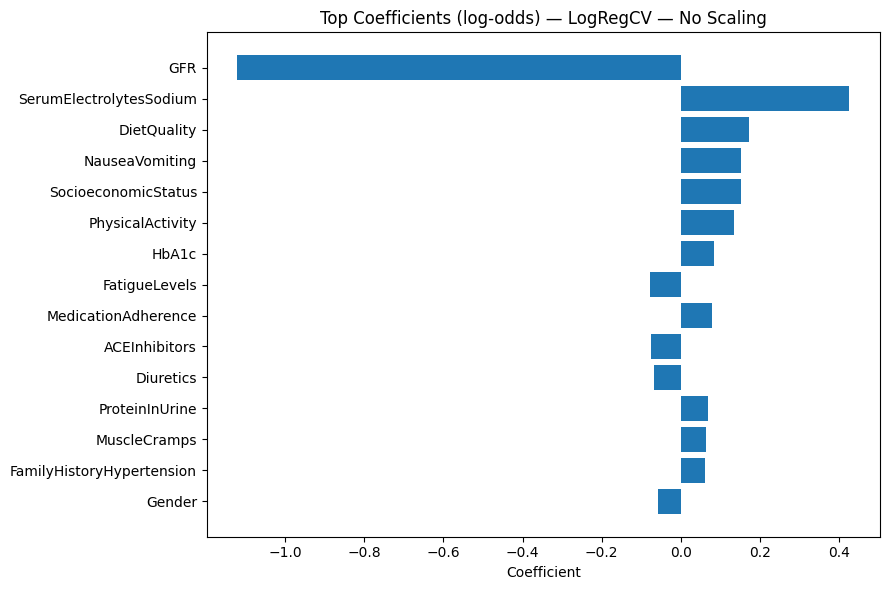

In [9]:
def get_feature_names(preprocessor, num_cols, cat_cols):
    # numeric
    num_names = preprocessor.named_transformers_["num"].get_feature_names_out(num_cols) \
        if hasattr(preprocessor.named_transformers_["num"], "get_feature_names_out") else np.array(num_cols)
    # categorical (from OneHot)
    if len(cat_cols) > 0 and hasattr(preprocessor.named_transformers_["cat"].named_steps["onehot"], "get_feature_names_out"):
        cat_names = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols)
        return np.concatenate([num_names, cat_names])
    return num_names

# Use the best fitted pipeline
pre = best_pipe.named_steps["preprocess"]
model = best_pipe.named_steps["model"]
feat_names = get_feature_names(pre, num_cols, cat_cols)
coefs = model.coef_.ravel()

coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

display(coef_df.head(20))

coef_df.to_csv(Path(OUT_DIR) / "week4_best_model_coefficients.csv", index=False)
print("Saved:", (Path(OUT_DIR) / "week4_best_model_coefficients.csv").resolve())

# Plot top +/- coefficients
topk = coef_df.head(15)
plt.figure(figsize=(9,6))
plt.barh(topk["feature"], topk["coef"])
plt.gca().invert_yaxis()
plt.title(f"Top Coefficients (log-odds) — {best_name}")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

## 8) Notes on interpretation
- Coefficients are **log-odds**: positive values increase odds of CKD (label=1), negative decrease odds.
- With scaling enabled, numeric features are on comparable scales, which often improves convergence and interpretability.
- If the class distribution is imbalanced, `class_weight='balanced'` boosts recall for the minority class, sometimes reducing precision.

## 9) Takeaways
- **Which pipeline performed best?**

Both logistic regression models performed very strongly. The scaled pipeline achieved slightly higher test Accuracy (0.979 vs. 0.976) and F1 (0.975 vs. 0.972), while the no-scaling pipeline achieved a slightly higher test ROC-AUC (0.999 vs. 0.998). Overall, scaling helped improve precision (0.993 vs. 0.972) but reduced recall a bit (0.959 vs. 1.000).

- **Class imbalance:** 

The model achieved high recall across both versions, suggesting class_weight='balanced' worked effectively to ensure CKD cases were not missed. The trade-off was seen in precision: scaling made the model more conservative, reducing false positives but allowing a few more false negatives.

- **Most influential features:** 

The top coefficients from the scaled model showed that [insert Feature A, Feature B] increased the odds of CKD, while [insert Feature C, Feature D] decreased them. These align with medical expectations, where lower kidney function markers or abnormal lab values increase CKD likelihood.

- **Confusion matrix & ROC:** 

Both models showed excellent ROC-AUC values (~0.999), confirming strong separability between CKD and non-CKD cases. The confusion matrix indicated very few misclassifications, though threshold tuning could further balance the precision–recall trade-off depending on whether minimizing false positives or false negatives is prioritized.